# Final Project {-}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import differential_evolution, newton

# Analytic Solutions {-}

## 1. {-}

To show that the volatility process is normally distributed, we first define $X_t = \sigma_t e^{\kappa t}$ and use Ito's Lemma to get

\begin{align*}
    dX_t &= d\left(\sigma_t e^{\kappa t}\right) = e^{\kappa t}\left(\kappa\sigma_t dt + d\sigma_t\right)\\
    &= e^{\kappa t}\left(\kappa\sigma_t dt + \kappa(\theta - \sigma_t)dt + \alpha dZ_t\right)\\
    &= e^{\kappa t}\left(\kappa\theta dt + \alpha dZ_t\right)\\
\end{align*}

Integrating the process from $s$ to $t$, where $s<t$, gives us

\begin{gather*}
    d\left(\sigma_t e^{\kappa t}\right) = e^{\kappa t}\left(\kappa\theta dt + \alpha dZ_t\right)\\
    \sigma_t e^{\kappa t} - \sigma_s e^{\kappa s} = \kappa \int_s^t \theta e^{\kappa w} dw + \alpha \int_s^t e^{\kappa w} dZ_w\\
    \sigma_t e^{\kappa t} = \sigma_s e^{\kappa s} + \kappa \int_s^t \theta e^{\kappa w} dw + \alpha \int_s^t e^{\kappa w} dZ_w\\
    \sigma_t = \sigma_s e^{-\kappa(t-s)} + \kappa \int_s^t \theta e^{-\kappa(t-w)} dw + \alpha \int_s^t e^{-\kappa(t-w)} dZ_w\\
    \sigma_t = \sigma_s e^{-\kappa(t-s)} + \theta\left(1 - e^{-\kappa(t-s)}\right) + \alpha \int_s^t e^{-\kappa(t-w)} dZ_w\\
\end{gather*}

The first two terms, $\sigma_s e^{-\kappa(t-s)} + \theta\left(1 - e^{-\kappa(t-s)}\right)$ are constants, while the Ito integral is normally distributed. This means that $\sigma_t$ is normally distributed.

We evaluate the conditional mean below, redefining the bounds from above to be $t$ to $T$ instead of $s$ to $t$.

\begin{align*}
    \mathbb{E}\left[\sigma_T \mid \mathcal{F}_t\right] &= \mathbb{E}\left[\sigma_t e^{-\kappa(T-t)} + \theta\left(1 - e^{-\kappa(T-t)}\right) + \alpha \int_t^T e^{-\kappa(T-w)} dZ_w \mid \mathcal{F}_t\right]\\
    &= \sigma_t e^{-\kappa(T-t)} + \theta\left(1 - e^{-\kappa(T-t)}\right) + \alpha~\mathbb{E}\left[\int_t^T e^{-\kappa(T-w)} dZ_w\mid \mathcal{F}_t\right] + 0\\
    &= \sigma_t e^{-\kappa(T-t)} + \theta\left(1 - e^{-\kappa(T-t)}\right)
\end{align*}

Hence we have

\begin{align*}
     \mathbb{E}\left[\sigma_T \mid \mathcal{F}_t\right] = \sigma_t e^{-\kappa(T-t)} + \theta\left(1 - e^{-\kappa(T-t)}\right) = \theta + e^{-\kappa (T-t)}\left(\sigma_t - \theta\right)
\end{align*}

To find the conditional variance, we use the definition of $\sigma_T$ and $\mathbb{E}\left[\sigma_T \mid \mathcal{F}_t\right]$, along with Ito's Isometry.

\begin{align*}
    \mathbb{E}\left[\left(\sigma_T - \mathbb{E}\left[\sigma_T\mid\mathcal{F}_t\right]\right)^2\mid\mathcal{F}_t\right] &= \mathbb{E}\left[\left(\sigma_t e^{-\kappa(T-t)} + \theta\left(1 - e^{-\kappa(T-t)}\right) + \alpha \int_t^T e^{-\kappa(T-w)} dZ_w - \left(\sigma_t e^{-\kappa(T-t)} + \theta\left(1 - e^{-\kappa(T-t)}\right)\right)\right)^2\mid\mathcal{F}_t\right]\\
    &= \alpha^2\mathbb{E}\left[\left(\int_t^T e^{-\kappa(T-w)} dZ_w\right)^2\mid\mathcal{F}_t\right]\\
    &= \alpha^2\mathbb{E}\left[\int_t^T e^{-2\kappa(T-w)} dw\mid\mathcal{F}_t\right]\\
    &= \alpha^2\left(\frac{e^{-2\kappa(T-w)}}{2\kappa}\right]_t^T\\
    &= \frac{\alpha^2}{2\kappa}\left(1 - e^{-2\kappa(T-t)}\right)\\
\end{align*}

Thus we have

\begin{align*}
    \mathbb{E}\left[\left(\sigma_T - \mathbb{E}\left[\sigma_T\mid\mathcal{F}_t\right]\right)^2\mid\mathcal{F}_t\right] = \frac{\alpha^2}{2\kappa}\left(1 - e^{-2\kappa(T-t)}\right)\\
\end{align*}

## 2. {-}

Using the definition of variance, we can find the instantaneous T-forward variance $\xi_t^T$ with our results from the previous problem.

\begin{gather*}
    \operatorname{Var}\left(\sigma_T \mid \mathcal{F}_t\right) = \mathbb{E}\left[\sigma_T^2 \mid \mathcal{F}_t\right] - \mathbb{E}\left[\sigma_T \mid \mathcal{F}_t\right]^2\\
    \operatorname{Var}\left(\sigma_T \mid \mathcal{F}_t\right) = \xi_t^T - \mathbb{E}\left[\sigma_T \mid \mathcal{F}_t\right]^2\\
    \xi_t^T = \operatorname{Var}\left(\sigma_T \mid \mathcal{F}_t\right) + \mathbb{E}\left[\sigma_T \mid \mathcal{F}_t\right]^2
\end{gather*}

Thus we get

\begin{align*}
    \xi_t^T &= \operatorname{Var}\left(\sigma_T \mid \mathcal{F}_t\right) + \mathbb{E}\left[\sigma_T \mid \mathcal{F}_t\right]^2\\
    &= \frac{\alpha^2}{2\kappa}\left(1 - e^{-2\kappa(T-t)}\right) + \left(\theta + e^{-\kappa (T-t)}\left(\sigma_t - \theta\right)\right)^2\\
    &= \frac{\alpha^2}{2\kappa}\left(1 - e^{-2\kappa(T-t)}\right) + \left(\theta^2 + e^{-2\kappa (T-t)}\left(\sigma_t - \theta\right)^2 + 2 \theta e^{-\kappa (T-t)}\left(\sigma_t - \theta\right)\right)\\
    &= \frac{\alpha^2}{2\kappa} + \theta^2 + 2 \theta e^{-\kappa (T-t)}\left(\sigma_t - \theta\right) + e^{-2\kappa (T-t)}\left(\left(\sigma_t - \theta\right)^2 - \frac{\alpha^2}{2\kappa}\right)
\end{align*}

## 3. {-}

Using the definition from lecture of the model break-even variance strike, we find it to be

\begin{align*}
    \operatorname{VS}_t &= \frac{1}{T-t}\int_t^T \xi_t^s ds\\
    &= \frac{1}{T-t}\int_t^T \left(\frac{\alpha^2}{2\kappa} + \theta^2 + 2 \theta e^{-\kappa (s-t)}\left(\sigma_t - \theta\right) + e^{-2\kappa (s-t)}\left(\left(\sigma_t - \theta\right)^2 - \frac{\alpha^2}{2\kappa}\right)\right) ds\\
    &= \frac{1}{T-t}\left(\left(\frac{\alpha^2}{2\kappa} + \theta^2\right)s - \frac{2 \theta e^{-\kappa (s-t)}}{\kappa}\left(\sigma_t - \theta\right) - \frac{e^{-2\kappa (s-t)}}{2\kappa}\left(\left(\sigma_t - \theta\right)^2 - \frac{\alpha^2}{2\kappa}\right)\right]_t^T\\
    &= \frac{1}{T-t}\left(\left(\frac{\alpha^2}{2\kappa} + \theta^2\right)(T-t) - \frac{2 \theta\left(\sigma_t - \theta\right)}{\kappa}\left(e^{-\kappa (T-t)} - 1\right) - \frac{\left(\sigma_t - \theta\right)^2 - \frac{\alpha^2}{2\kappa}}{2\kappa}\left(e^{-2\kappa (T-t)} - 1\right)\right)\\
    &= \frac{\alpha^2}{2\kappa} + \theta^2 + \frac{1 - e^{-\kappa (T-t)}}{\kappa(T-t)}\left(2 \theta\left(\sigma_t - \theta\right)\right) + \frac{1 - e^{-2\kappa (T-t)}}{2\kappa (T-t)}\left(\left(\sigma_t - \theta\right)^2 - \frac{\alpha^2}{2\kappa}\right)\\
\end{align*}

Note this can be rewritten from 0 to $T$, replacing $t$ with 0 to have

\begin{align*}
    \operatorname{VS}_0 &= \frac{\alpha^2}{2\kappa} + \theta^2 + \frac{1 - e^{-\kappa T}}{\kappa T}\left(2 \theta\left(\sigma_0 - \theta\right)\right) + \frac{1 - e^{-2\kappa T}}{2\kappa T}\left(\left(\sigma_0 - \theta\right)^2 - \frac{\alpha^2}{2\kappa}\right)\\
\end{align*}

If we let $T\rightarrow\infty$, then the last two terms converge to 0 with the $T-t$ term in the denominator in each. Thus we have

\begin{align*}
    \lim_{T\rightarrow\infty} \operatorname{VS}_t = \frac{\alpha^2}{2\kappa} + \theta^2
\end{align*}

# Calibration to Variance Strike Term Structure {-}

## Downloading and Cleaning the Data {-}

In [2]:
futures = pd.read_csv("cme.settle.20221108.s.csv",parse_dates=["LastTrdDt"])

# Delete the columns that aren't useful for the final project
futures = futures.drop(columns=['BizDt', 'ID', 'MMY', 'MatDt',
       'Exch', 'Desc', 'BidPrice', 'OpeningPrice',
       'SettleDelta', 'HighLimit', 'LowLimit', 'DHighPrice', 'DLowPrice',
       'HighBid', 'LowBid', 'PrevDayVol', 'PrevDayOI', 'FixingPrice',
       'UndlyExch', 'UndlyID', 'UndlySecTyp', 'UndlyMMY', 'BankBusDay'])

## 4. {-}

We set up some functions that we will use later on.

In [3]:
def integrate(x,f_x):
    # Trapezoidal rule for approximating integrals
    delta_f = f_x[:-1] + f_x[1:]
    delta_x = x[1:] - x[:-1]
    return 0.5 * np.sum(delta_f * delta_x)

def market_break_even_var_strike(call,put,strike,F,r,T):
    # Calculate the market break-even variance strikes
    put_strikes = K[K <= F]
    integral_put = put[K <= F]
    integral_put /= (put_strikes * put_strikes)
    
    call_strikes = K[K > F]
    integral_call = call[K > F]
    integral_call /= (call_strikes * call_strikes)
    
    return (2 * np.exp(r*T) / T) * (integrate(put_strikes,integral_put) + integrate(call_strikes,integral_call))

def risk_free_rate(C,P,F,K,tau):
    # Find the risk-free rate using put-call parity
    discount = ((C - P) / (F-K))
    return np.median(np.log(discount) / (-tau))

For each date, we find the break-even variance strike with the formula

\begin{align*}
    \operatorname{VS}_0 = \frac{2}{T}\left(\int_0^{F_T} \frac{1}{K^2}P(T,K)dK + \int_{F_T}^\infty \frac{1}{K^2}C(T,K)dK\right)
\end{align*}

Here we use a trapezoid approximation to calculate the integrals. We print out the approximate values and the graph of the break-even variance strikes below.

Break-Even Variance Strike on 2022-11-25: 0.678728
Break-Even Variance Strike on 2022-12-30: 0.586597
Break-Even Variance Strike on 2023-01-27: 0.562070
Break-Even Variance Strike on 2023-02-24: 0.444393
Break-Even Variance Strike on 2023-03-31: 0.377091
Break-Even Variance Strike on 2023-04-28: 0.429625
Break-Even Variance Strike on 2023-06-30: 0.348947
Break-Even Variance Strike on 2023-09-29: 0.553100
Break-Even Variance Strike on 2023-12-29: 0.681495
Break-Even Variance Strike on 2024-03-28: 0.636785


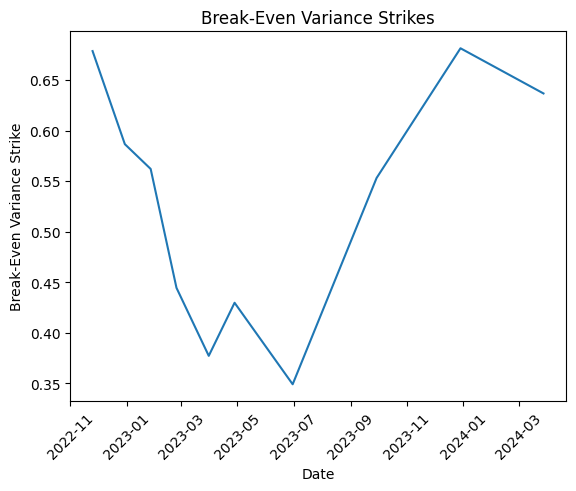

In [4]:
# Get the bitcoin data
start_date = np.datetime64('2022-11-08')
bitcoin = futures[(futures["Sym"] == "BTC") & (futures["SettlePrice"] != 9999999.0)]
dates = [np.datetime64(d,"D") for d in bitcoin["LastTrdDt"].unique()]

date_data = {d:{} for d in dates}
tau = []
market_var_strikes = []

for d in dates:
    # Get relevant info for each expiration date
    btc_day = bitcoin[(bitcoin["LastTrdDt"] == d)]
    puts = btc_day[(btc_day["SecTyp"] == "OOF") & (btc_day["PutCall"] == 0)]
    calls = btc_day[(btc_day["SecTyp"] == "OOF") & (btc_day["PutCall"] == 1)]
    put_call = calls.merge(puts,on="StrkPx",suffixes=('_C', '_P'))
    
    C = put_call["SettlePrice_C"].values
    P = put_call["SettlePrice_P"].values
    K = put_call["StrkPx"].values
    F = btc_day[btc_day["SecTyp"] == "FUT"]["SettlePrice"].to_numpy()[0]
    T = (d - start_date) / (365*np.timedelta64(1, 'D'))
    r = risk_free_rate(C,P,F,K,T)
    
    # Calculae break-even variance strike
    break_even_var_strike_for_T = market_break_even_var_strike(C,P,K,F,r,T)
    market_var_strikes.append(break_even_var_strike_for_T)
    
    # Add data to dictionary
    date_data[d]["T"] = T
    date_data[d]["F"] = F
    date_data[d]["r"] = r
    date_data[d]["Calls"] = C
    date_data[d]["Puts"] = P
    date_data[d]["Strikes"] = K
    date_data[d]["Market Var Strike"] = break_even_var_strike_for_T
    tau.append(T)
    
# Print and plot the results
tau = np.array(tau)
market_var_strikes = np.array(market_var_strikes)
for d,be in zip(dates,market_var_strikes):
    date_data[d]["Break-Even Var Strike"] = be
    print("Break-Even Variance Strike on {}: {:.6f}".format(d,be))
    
plt.plot(dates,market_var_strikes,label="Market")
plt.title("Break-Even Variance Strikes")
plt.xlabel("Date"); plt.xticks(rotation=45)
plt.ylabel("Break-Even Variance Strike")
plt.show()

## 5. {-}

To calibrate the Stein and Stein model, we use `differential_evolution` from `scipy` to minimize the mean-squared error (MSE) between the market break-even variance strikes  and the formula found from the model, which is

\begin{align*}
    \operatorname{VS}_0 &= \frac{\alpha^2}{2\kappa} + \theta^2 + \frac{1 - e^{-\kappa T}}{\kappa T}\left(2 \theta\left(\sigma_0 - \theta\right)\right) + \frac{1 - e^{-2\kappa T}}{2\kappa T}\left(\left(\sigma_0 - \theta\right)^2 - \frac{\alpha^2}{2\kappa}\right)\\
\end{align*}

We find the calibrated parameters and print them below in the table.

In [5]:
def analytical_break_even_var_strike(params,T):
    # Analytical break-even variance srike using Stein & Stein model
    kappa = params[0]; theta = params[1]; alpha = params[2]; sig0 = params[3]
    
    result = (alpha * alpha / (2 * kappa)) + theta * theta
    result += ((1 - np.exp(-kappa*T)) * (2*theta*(sig0 - theta))) / (kappa*T)
    result += ((1 - np.exp(-2*kappa*T)) * ((sig0 - theta)**2 - (alpha*alpha / (2*kappa)))) / (2*kappa*T)
    return result

def var_strike_min(params,T,var_strikes):
    # Minimize the break-even variance strikes between market and model
    stein_var_strikes = analytical_break_even_var_strike(params,T)
    return np.mean(np.square(var_strikes - stein_var_strikes))

# Initial values
kappa_init = 0.0410
theta_init = 0.1331
alpha_init = 0.3586
sig0_init = 0.3060

# Find the optimal parameters
BOUND = 10
bounds = [(0,BOUND), (-BOUND, BOUND), (0,BOUND),(0, BOUND)]
x_init = (kappa_init, theta_init, alpha_init, sig0_init)
stein_stein_result = differential_evolution(var_strike_min,bounds,seed=8,
                                            args=(tau,market_var_strikes),polish = True,maxiter = 1000)
calibrated_params = stein_stein_result.x

# Store the result in a dataframe
stein_stein_df = pd.DataFrame(columns = [r"$\kappa$",r"$\theta$",r"$\alpha$",r"$\sigma_0$"])
stein_stein_df.loc[0,:] = calibrated_params
stein_stein_df.index = ["Calibrated Values"]
stein_stein_df

,$\kappa$,$\theta$,$\alpha$,$\sigma_0$
Calibrated Values,1.741401,-1.026245,1.274708,0.894652


We also plot the break-even variance strikes with our calibrated parameters to compare the curves. Looking at the fit, the Stein & Stein model does a good job estimating the break-even variance strikes. The model captures the tails well, while having the biggest difference in the middle.

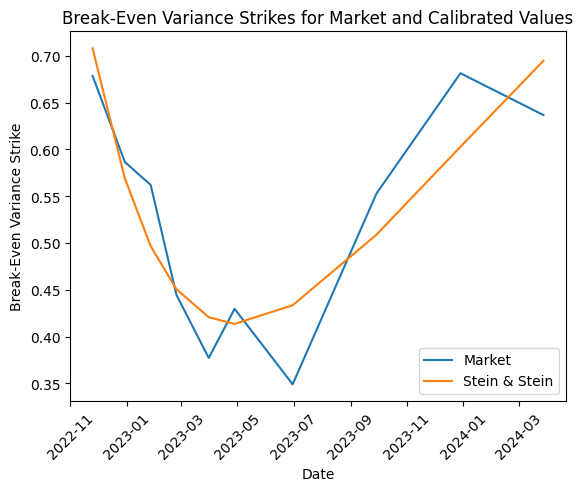

In [6]:
calibrated_var_strikes = analytical_break_even_var_strike(calibrated_params,tau)
plt.plot(dates,market_var_strikes,label="Market")
plt.plot(dates,calibrated_var_strikes,label="Stein & Stein")

plt.title("Break-Even Variance Strikes for Market and Calibrated Values")
plt.xlabel("Date"); plt.xticks(rotation=45)
plt.ylabel("Break-Even Variance Strike")
plt.legend()
plt.show()

# Monte Carlo Simulation {-}

## 6. {-}

We first create a function for our simulation of the Stein & Stein model, using an Euler discretization for the futures price and the true distribution of the volatiliy process. We make use of the formulas

\begin{gather*}
    F_{t+\Delta t} = F_t \exp\left(\sigma_t\sqrt{\Delta_t}W - \frac{1}{2}\sigma^2 \Delta t\right)\\
    \sigma_{t+\Delta t} = \theta + e^{-\kappa (\Delta t)}\left(\sigma_t - \theta\right) + \sqrt{\frac{\alpha^2}{2\kappa}\left(1 - e^{-2\Delta t)}\right)}Z
\end{gather*}

where $W\sim\operatorname{N}(0,1), Z\sim\operatorname{N}(0,1)$, and $\operatorname{Corr}(W,Z) = \rho$.

In [7]:
def stein_stein_simulation(F0,stein_params,rho,num_sims,T,num_steps,norms=None):
    # Simulate the futures prices and Stein & Stein volatility
    kappa = stein_params[0]; theta = stein_params[1]; alpha = stein_params[2]; sig0 = stein_params[3]
    delta_t = T / num_steps
    
    if norms == None:
        W = np.random.normal(size=(num_sims,num_steps))
        Z = rho * W + np.sqrt(max(0,1-rho*rho)) * np.random.normal(size=(num_sims,num_steps))
    else:
        W = norms[0]; Z = norms[1]

    stein_vol = np.zeros((num_sims,num_steps+1))
    stein_vol[:,0] = sig0
    fut_price = np.zeros((num_sims,num_steps+1))
    fut_price[:,0] = F0
    
    # Generate the paths for future prices and volatiliy
    for i in range(num_steps):
        stein_vol[:,i+1] = theta + np.exp(-kappa*delta_t)*(stein_vol[:,i] - theta)\
                           + np.sqrt((alpha*alpha/(2*kappa)) * (1 - np.exp(-2*kappa*delta_t))) * Z[:,i]
    
        fut_price[:,i+1] = fut_price[:,i] * np.exp(stein_vol[:,i] * np.sqrt(delta_t) * W[:,i] 
                                                   - 0.5 * np.square(stein_vol[:,i]) * delta_t)
    
    return fut_price, stein_vol

def monte_carlo_forward_put_premium(F0,K,stein_params,rho,num_sims,T,num_steps,norms=None):
    # Calculate the forward put premium for the futures prices
    future_prices = stein_stein_simulation(F0,stein_params,rho,num_sims,T,num_steps,norms=norms)[0]
    est_prices = np.array([np.mean(np.maximum(k - future_prices[:,-1], 0)) for k in K])
    return est_prices

We now find the best value of $\rho$ that minimizes the MSE between the forward put premium and the payoff of the puts. Here, we define the forward put premium as

$$FPP = \frac{1}{2}\left(\frac{C+P}{D} + K - F\right)$$

where $C$ is the call price, $P$ is the put price, $K$ is the strike price, and $F$ is the futures price. We can rewrite this as 

\begin{align*}
    FPP &= \frac{1}{2}\left(\frac{C+P}{D} + K - F\right)\\
    &= \frac{1}{2}\left(\frac{P}{D} + \left(\frac{C}{D} + K - F\right)\right)\\
    &= \frac{1}{2}\left(\frac{P}{D} + \frac{P}{D}\right)\\
    &= \frac{P}{D}
\end{align*}

Therefore, we use market call and put prices to find the forward put premium and then find the non-discounted payoff put. We do this for a range of $\rho$'s to find the lowest MSE. We plot the picture of the different $\rho$ values versus the MSE's below, along with the best MSE to use. For this model, the best value of $\rho$ tends to be around -0.5 to -0.3.

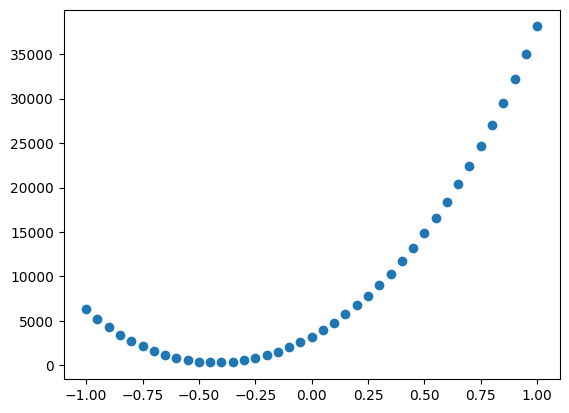

The best value of rho is -0.40


In [8]:
end_date = np.datetime64('2022-12-30')
T = (end_date - start_date) / (365*np.timedelta64(1, 'D'))
num_steps = int((end_date - start_date) / np.timedelta64(1, 'D'))
num_sims = 100000

r = date_data[end_date]["r"]
F0 = date_data[end_date]["F"]
call_prices = date_data[end_date]["Calls"]
put_prices = date_data[end_date]["Puts"]
strikes = date_data[end_date]["Strikes"]
forward_put_premium = 0.5 * (((put_prices + call_prices) / np.exp(-r*T)) + strikes - F0)

# Preparing for possible rhos
possible_rho = np.arange(-1, 1.05, .05)
best_rho = np.inf
best_MSE = np.inf
MSE_vals = []

W = np.random.normal(size=(num_sims,num_steps))
X = np.random.normal(size=(num_sims,num_steps))

for rho_guess in possible_rho:
    Z = rho_guess * W + np.sqrt(max(0,1-rho_guess*rho_guess)) * X
    # Calculate the forward put premium to minimize the MSE
    est_forward_put_premium = \
        monte_carlo_forward_put_premium(F0,strikes,calibrated_params,rho_guess,num_sims,T,num_steps,norms=(W,Z))
    MSE = np.mean(np.square(est_forward_put_premium - forward_put_premium))
    MSE_vals.append(MSE)
    if MSE < best_MSE:
        best_MSE = MSE
        best_rho = rho_guess

plt.scatter(possible_rho,MSE_vals)
plt.show()
print("The best value of rho is {:.2f}".format(best_rho))

Using our best value of $\rho$, we simulate 1,000,000 paths to use in later parts.

In [9]:
num_sims = 1_000_000
future_prices, stein_vols = stein_stein_simulation(F0,calibrated_params,best_rho,num_sims,T,num_steps)

## 7. {-}

Now with all of our parameters, we find the volatility smiles for the market and the model. For each stirke, we find the implied volatility with respect to the Black-Scholes forward put price. For the market, we use the forward put price, while we use a non-discounted put payoff for the model. Plotting the implied volatilities versus the log srikes, we see that there is more noise with higher strikes for the market. With the model, the implied volatilites are lower than the markets for lower strikes, while increasing the strike price makes the  model fit closely to the market.

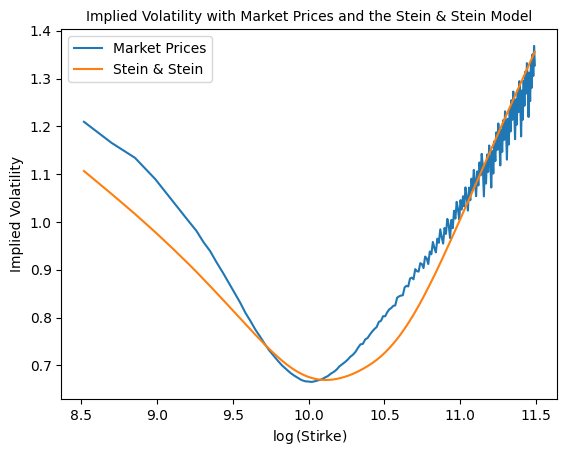

In [10]:
def black_scholes_forward_put_premium(F, K, T, terminalVolatility):
    # Black's formula for a put, without discounting
    if terminalVolatility <= 0.0:
        return np.maximum(0.0, K - F)
    d1 = np.log (F / K) / (terminalVolatility * np.sqrt(T)) + 0.5 * terminalVolatility * np.sqrt(T)
    d2 = d1 - terminalVolatility * np.sqrt(T)
    return K * norm.cdf(-d2) - F * norm.cdf(-d1)

def forward_put_premium_price_diff(sigma_imp, F0, K, T, forward_put_price):
    # Difference in prices between market/model and Black's formula
    return black_scholes_forward_put_premium(F0, K, T, sigma_imp) - forward_put_price

market_implied_vols = []
model_implied_vols = []
vol0 = 1.2

for K,fpp in zip(strikes,forward_put_premium):
    # Implied vol for market prices
    market_imp_vol = newton(forward_put_premium_price_diff,vol0,args=(F0, K, T, fpp))
    market_implied_vols.append(market_imp_vol)
    
    # Implied vol for model prices
    model_put = np.mean(np.maximum(K - future_prices[:,-1], 0.0))
    model_imp_vol = newton(forward_put_premium_price_diff,vol0,args=(F0, K, T, model_put))
    model_implied_vols.append(model_imp_vol)
    
    vol0 = min(market_imp_vol,model_imp_vol)
#     print(vol0, K)
    
# Plot the implied volatilities
model_implied_vols = np.array(model_implied_vols)
plt.plot(np.log(strikes),market_implied_vols,label="Market Prices")
plt.plot(np.log(strikes[model_implied_vols!=0]),model_implied_vols[model_implied_vols!=0],
         label="Stein & Stein")
plt.title("Implied Volatility with Market Prices and the Stein & Stein Model",size=10)
plt.xlabel(r"$\log$(Stirke)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

# Pricing Exotic Options {-}

## 8. {-}

To estimate the model continuous break-even volatility strike, we can use our volatility paths from our Stein & Stein model. The formula to find the continuous break-even volatility strike is 

$$K^{vol} = \mathbb{E}\left[\sqrt{\frac{1}{T} \int_0^T v_t dt}~\right]$$

For each simulation, we square each of the volatilities and use a trapezoidal approximation to compute the integral. Finally we take the square root of the result and average the paths to get our estimate, along with a standard error estimate as well.

In [11]:
delta_t = T / num_steps
time_steps = np.array([delta_t * i for i in range(num_steps+1)])

# Integrate each path to compue the continuous break-even volatility strike
vol_strike_integral = np.array([integrate(time_steps,np.square(stein_vols[i,:])) for i in range(num_sims)])
model_cont_break_even_vol_strikes = np.sqrt(vol_strike_integral / T)

model_cont_break_even_vol_strike_est = np.mean(model_cont_break_even_vol_strikes)
model_cont_break_even_vol_strike_stderr = np.std(model_cont_break_even_vol_strikes) / np.sqrt(num_sims)
print("The estimated model continuous break-even volatility strike is {:.6f} and the standard error is {:.6f}"
      .format(model_cont_break_even_vol_strike_est,model_cont_break_even_vol_strike_stderr))

The estimated model continuous break-even volatility strike is 0.723945 and the standard error is 0.000212


## 9. {-}

We price the down-and-out put options using our simulated futures paths from earlier. From there, we plot the price of the option as a function of the barriers and the strikes. Looking at our plot, we see that a lower barrier makes the option behave like a normal put price. However, increasing the barrier increases the chances of the option having no payout, thus decreasing the price. 

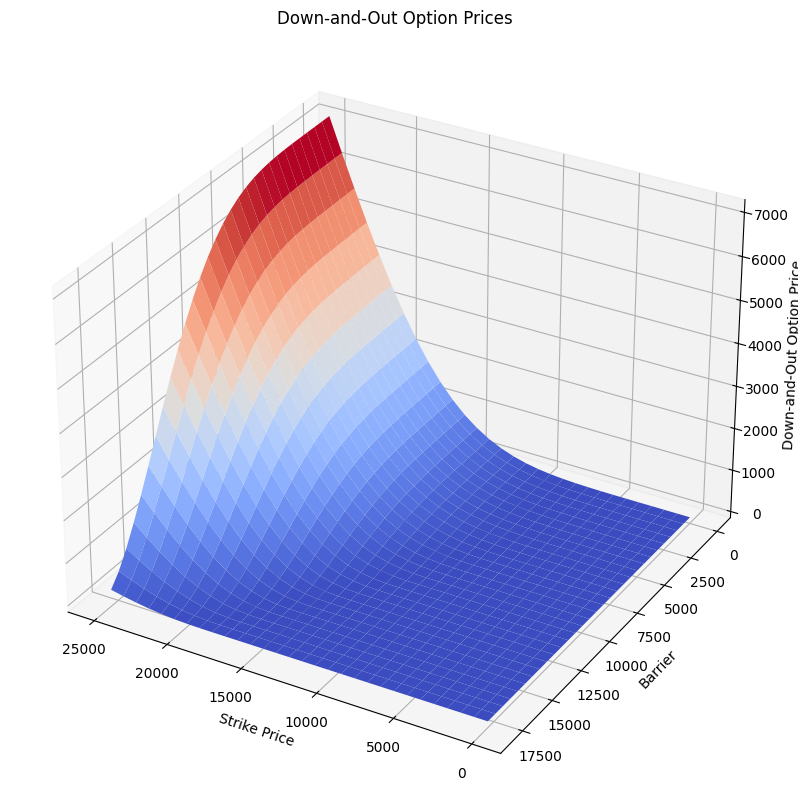

In [12]:
def price_down_and_out_put(futures_prices,K,B,r,T):
    # Price the down-and-out put option
    min_future_price = future_prices.min(axis=1)
    
    payoffs = np.where(min_future_price > B, np.maximum(K - future_prices[:,-1], 0), 0)
    price = np.mean(np.exp(-r*T) * payoffs)
    return price

# Set up grid points to use
num_points = 30
strikes = np.linspace(0, 25000, num=num_points)
barriers = np.linspace(0, 18000, num=num_points)
down_out_prices = np.zeros((num_points,num_points))

# Find the down-and-out put prices for each barrier and strike
for K,i in zip(strikes,range(num_points)):
    for B,j in zip(barriers,range(num_points)):
        down_out_prices[i,j] = price_down_and_out_put(future_prices,K,B,r,T)
        
# Plot the surface
plot_strikes = np.array([[k for _ in range(num_points)] for k in strikes])
plot_barriers = np.array([[b for b in barriers],] * num_points)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(plot_strikes,plot_barriers,down_out_prices,cmap='coolwarm', edgecolor='none')

ax.set_title('Down-and-Out Option Prices')
ax.set_xlabel('Strike Price', fontsize=10)
ax.set_ylabel('Barrier', fontsize=10)
ax.set_zlabel('Down-and-Out Option Price', fontsize=10)
plt.gca().invert_xaxis(); plt.gca().invert_yaxis()
plt.show()